<a href="https://colab.research.google.com/github/harshit-singh-hs/SAR_Project/blob/main/SAR_Despeckling_Using_U-Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Environment Setup & Google Drive Mounting

In [16]:
import os
from google.colab import drive

if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')

# Project Configuration
base_dir = '/content/drive/MyDrive/SAR_Project'
data_dir = os.path.join(base_dir, 'dataset')

# Define training paths
noisy_dir = os.path.join(data_dir, 'train', 'noisy')
clean_dir = os.path.join(data_dir, 'train', 'clean')

val_noisy_dir = os.path.join(data_dir, 'val', 'noisy')
val_clean_dir = os.path.join(data_dir, 'val', 'clean')


# Verify dataset availability
if os.path.exists(noisy_dir) and os.path.exists(clean_dir):
    # Count images
    n_noisy = len(os.listdir(val_noisy_dir)) + len(os.listdir(noisy_dir))
    n_clean = len(os.listdir(val_clean_dir)) + len(os.listdir(clean_dir))

    print(f"Dataset Path: {data_dir}")
    print(f"Found {n_noisy} noisy images and {n_clean} clean images.")

    if n_noisy != n_clean:
        print(f"Warning: Data mismatch! ({n_noisy} noisy vs {n_clean} clean)")
else:
    print(f"Error: Dataset directory not found at {data_dir}")
    print("Please check the folder structure in your Google Drive.")

Dataset Path: /content/drive/MyDrive/SAR_Project/dataset
Found 1600 noisy images and 1600 clean images.


### Importing Libraries

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from IPython.display import Image, display
import glob
import rasterio

### Dataset Configuration & Splitting

In [18]:
# Configuration
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 16

In [19]:
X_train = sorted(glob.glob(os.path.join(noisy_dir, '*.tiff')))
y_train = sorted(glob.glob(os.path.join(clean_dir, '*.tiff')))

X_val = sorted(glob.glob(os.path.join(val_noisy_dir, '*.tiff')))
y_val = sorted(glob.glob(os.path.join(val_clean_dir, '*.tiff')))

### Custom Data Generator Pipeline

In [20]:
def load_tiff_image(file_path):
    """Helper function to read .tiff and normalize it to 0-1"""
    with rasterio.open(file_path) as src:
        # Read the first band
        img = src.read(1)
        # Normalize to 0-1 range
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
        # Resize to 128x128
        img = tf.image.resize(img[..., np.newaxis], [128, 128]).numpy()
    return img

In [21]:
def data_generator(noisy_list, clean_list, batch_size=16):
    """Generator that yields batches of images """
    while True:
        for i in range(0, len(noisy_list), batch_size):
            batch_noisy_paths = noisy_list[i : i + batch_size]
            batch_clean_paths = clean_list[i : i + batch_size]

            batch_noisy = [load_tiff_image(p) for p in batch_noisy_paths]
            batch_clean = [load_tiff_image(p) for p in batch_clean_paths]

            yield np.array(batch_noisy), np.array(batch_clean)

In [22]:
# Initialize generators
train_gen = data_generator(X_train, y_train, batch_size=16)
val_gen = data_generator(X_val, y_val, batch_size=16)

print(f"Total training pairs: {len(X_train)}")

Total training pairs: 1500


### Visualizing the Raw SAR Data

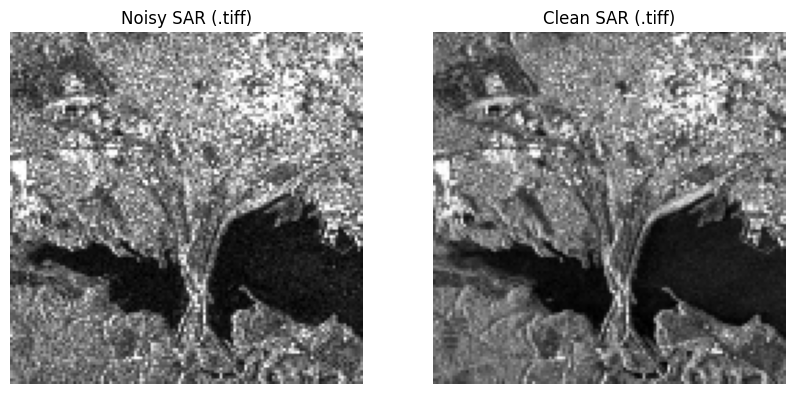

In [23]:
sample_noisy, sample_clean = next(train_gen)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Noisy SAR (.tiff)")
plt.imshow(sample_noisy[0].squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Clean SAR (.tiff)")
plt.imshow(sample_clean[0].squeeze(), cmap='gray')
plt.axis('off')

plt.show()

### U-Net Architecture

In [24]:
def build_unet(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)

    # ENCODER

    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)


    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # BOTTLENECK

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # DECODER

    u3 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u3 = layers.concatenate([u3, c3]) # Skip Connection 1
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c2]) # Skip Connection 1
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u1 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u1 = layers.concatenate([u1, c1]) # Skip Connection 2
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    # OUTPUT

    outputs = layers.Conv2D(1, (1, 1), activation='linear')(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs], name="SAR_UNet")
    return model


model = build_unet()

model.summary()

Model: "SAR_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    131,200 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │     32,832 │ conv2d_9[0][0]  

 Total params: 1,925,025 (7.34 MB)

 Trainable params: 1,925,025 (7.34 MB)

 Non-trainable params: 0 (0.00 B)

### Model Visualization

 U-Net Architecture Visualization:


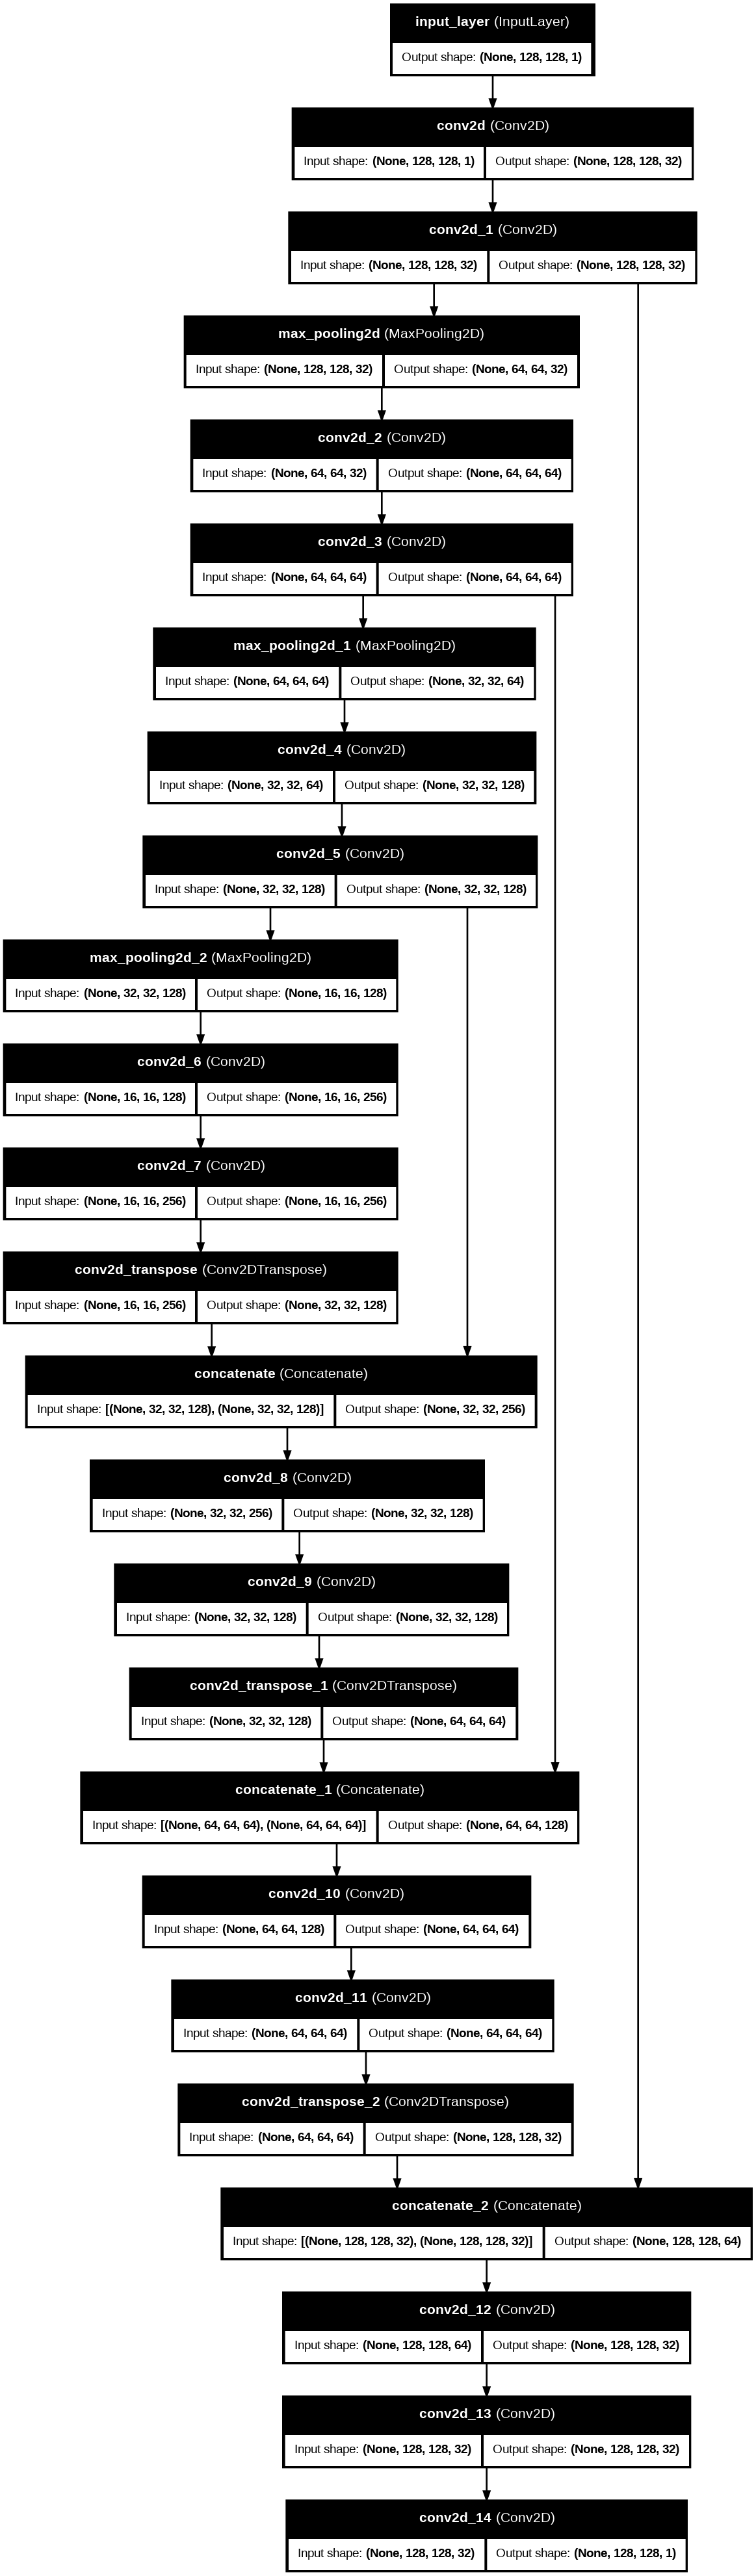

In [25]:
plot_path = 'sar_unet_diagram.png'

plot_model(
    model,
    to_file=plot_path,
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96
)

print(" U-Net Architecture Visualization:")
display(Image(plot_path))

### Custom Loss Functions & Metrics

In [26]:
# Custom Loss Function
def ssim_loss(y_true, y_pred):
    """Structural Similarity Loss: 1.0 - SSIM"""
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

def hybrid_loss(y_true, y_pred):
    """
    - 80% SSIM (Force it to keep edges sharp)
    - 20% MAE (Just ensure colors/brightness are correct)
    """
    mae = tf.keras.losses.MeanAbsoluteError()(y_true, y_pred)
    ssim = ssim_loss(y_true, y_pred)

    return 0.2 * mae + 0.8 * ssim

# Metric: Peak Signal-to-Noise Ratio (PSNR)
def psnr_metric(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

### Phase 1:Model Compilation & Training

In [27]:
# Compile the Model
model.compile(optimizer='adam', loss=hybrid_loss, metrics=[psnr_metric, 'mae'])

callbacks = [
    ModelCheckpoint('best_sar_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [28]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(X_train) // 16,  # 16 is batch size
    validation_steps=len(X_val) // 16,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:367: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


Epoch 1/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4958 - mae: 0.1580 - psnr_metric: 17.8929
Epoch 1: val_loss improved from inf to 0.20718, saving model to best_sar_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - loss: 0.4945 - mae: 0.1574 - psnr_metric: 17.9205 - val_loss: 0.2072 - val_mae: 0.0524 - val_psnr_metric: 23.3137 - learning_rate: 0.0010
Epoch 2/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3620 - mae: 0.0938 - psnr_metric: 20.6234
Epoch 2: val_loss improved from 0.20718 to 0.20357, saving model to best_sar_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - loss: 0.3616 - mae: 0.0936 - psnr_metric: 20.6339 - val_loss: 0.2036 - val_mae: 0.0487 - val_psnr_metric: 23.8825 - learning_rate: 0.0010
Epoch 3/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3501 - mae: 0.0880 - psnr_metric: 21.2076
Epoch 3: val_loss improved from 0.20357 to 0.19707, saving model to best_sar_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - loss: 0.3498 - mae: 0.0879 - psnr_metric: 21.2157 - val_loss: 0.1971 - val_mae: 0.0476 - val_psnr_metric: 24.1880 - learning_rate: 0.0010
Epoch 4/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3406 - mae: 0.0828 - psnr_metric: 21.8803
Epoch 4: val_loss improved from 0.19707 to 0.19489, saving model to best_sar_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - loss: 0.3404 - mae: 0.0827 - psnr_metric: 21.8853 - val_loss: 0.1949 - val_mae: 0.0462 - val_psnr_metric: 24.5602 - learning_rate: 0.0010
Epoch 5/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3316 - mae: 0.0790 - psnr_metric: 22.2721
Epoch 5: val_loss did not improve from 0.19489
93/93 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - loss: 0.3315 - mae: 0.0790 - psnr_metric: 22.2745 - val_loss: 0.2010 - val_mae: 0.0506 - val_psnr_metric: 24.1117 - learning_rate: 0.0010
Epoch 6/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3269 - mae: 0.0775 - psnr_metric: 22.5362
Epoch 6: val_loss did not improve from 0.19489
93/93 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - loss: 0.3268 - mae: 0.0775 - psnr_metric: 22.5373 - val_loss: 0.2016 - val_mae: 0.0511 - val_psnr_metric: 24.0639 - learning_rate: 0.0010
Epoch 7/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3232 - mae: 0.0766 - psnr_metric: 22.5193
Epoch 7: val_loss did not improve from 0.19489

Epoch 7: Reduce

93/93 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - loss: 0.3091 - mae: 0.0699 - psnr_metric: 22.9738 - val_loss: 0.1933 - val_mae: 0.0457 - val_psnr_metric: 24.7826 - learning_rate: 5.0000e-04
Epoch 11/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3038 - mae: 0.0687 - psnr_metric: 23.0842
Epoch 11: val_loss improved from 0.19333 to 0.19263, saving model to best_sar_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - loss: 0.3040 - mae: 0.0687 - psnr_metric: 23.0814 - val_loss: 0.1926 - val_mae: 0.0470 - val_psnr_metric: 24.5940 - learning_rate: 5.0000e-04
Epoch 12/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2991 - mae: 0.0674 - psnr_metric: 23.1943
Epoch 12: val_loss did not improve from 0.19263
93/93 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - loss: 0.2993 - mae: 0.0675 - psnr_metric: 23.1905 - val_loss: 0.1988 - val_mae: 0.0501 - val_psnr_metric: 24.2302 - learning_rate: 5.0000e-04
Epoch 13/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2979 - mae: 0.0679 - psnr_metric: 23.0833
Epoch 13: val_loss did not improve from 0.19263
93/93 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - loss: 0.2981 - mae: 0.0679 - psnr_metric: 23.0803 - val_loss: 0.1984 - val_mae: 0.0501 - val_psnr_metric: 24.2067 - learning_rate: 5.0000e-04
Epoch 14/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2929 - mae: 0.0663 - psnr_metric: 23.2735
Epoch 14: val_loss did not improve from 0.1926

93/93 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - loss: 0.2789 - mae: 0.0610 - psnr_metric: 23.8252 - val_loss: 0.1903 - val_mae: 0.0450 - val_psnr_metric: 24.8545 - learning_rate: 1.2500e-04
Epoch 19/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2750 - mae: 0.0601 - psnr_metric: 23.8559
Epoch 19: val_loss did not improve from 0.19029
93/93 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - loss: 0.2754 - mae: 0.0602 - psnr_metric: 23.8479 - val_loss: 0.1950 - val_mae: 0.0449 - val_psnr_metric: 24.8765 - learning_rate: 1.2500e-04
Epoch 20/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2728 - mae: 0.0591 - psnr_metric: 23.9656
Epoch 20: val_loss did not improve from 0.19029
93/93 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - loss: 0.2733 - mae: 0.0592 - psnr_metric: 23.9567 - val_loss: 0.1950 - val_mae: 0.0456 - val_psnr_metric: 24.7712 - learning_rate: 1.2500e-04
Epoch 21/50
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.2703 - mae: 0.0585 - psnr_metric: 24.0416
Epoch 21: val_loss did not improve from 0.1902

### Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


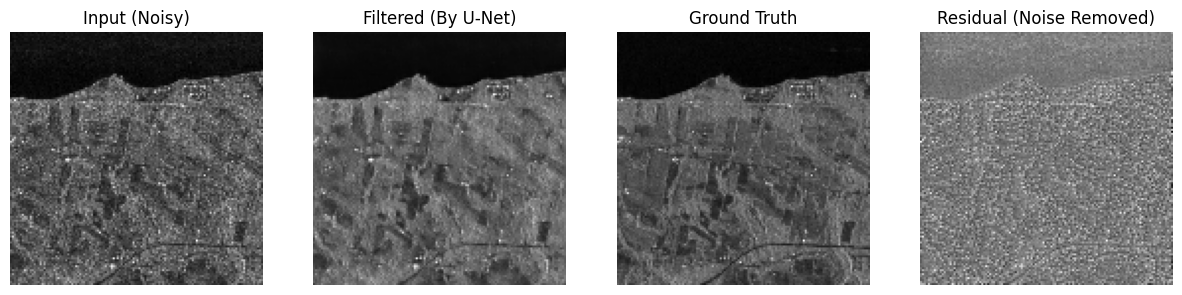

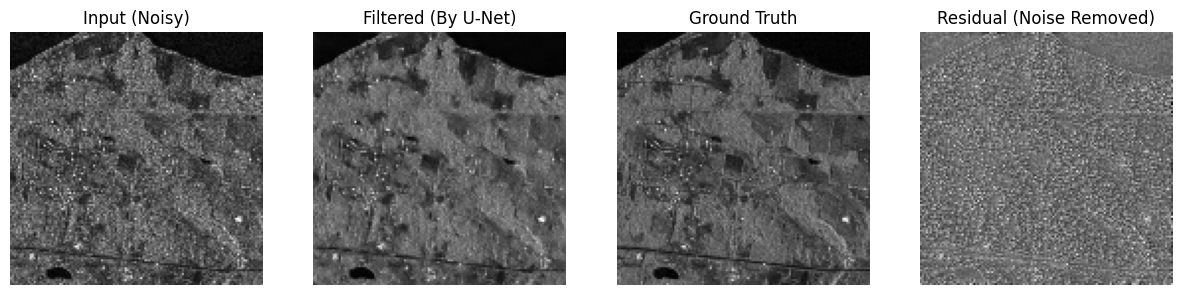

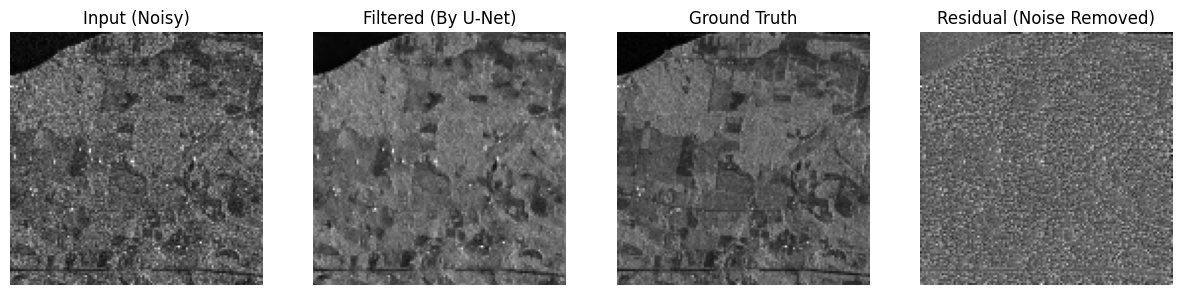

In [29]:
best_model = tf.keras.models.load_model(
    'best_sar_model.h5',
    custom_objects={'hybrid_loss': hybrid_loss, 'psnr_metric': psnr_metric}
)

# Get a single batch of validation images
val_noisy, val_clean = next(val_gen)

# Run Prediction
denoised_images = best_model.predict(val_noisy)

# Plot Results
def plot_results(noisy, clean, denoised, index=0):
    plt.figure(figsize=(15, 5))

    # Noisy Input
    plt.subplot(1, 4, 1)
    plt.title("Input (Noisy)")
    plt.imshow(noisy[index].squeeze(), cmap='gray')
    plt.axis('off')

    # Your Model's Output
    plt.subplot(1, 4, 2)
    plt.title("Filtered (By U-Net)")
    plt.imshow(denoised[index].squeeze(), cmap='gray')
    plt.axis('off')

    # Ground Truth
    plt.subplot(1, 4, 3)
    plt.title("Ground Truth")
    plt.imshow(clean[index].squeeze(), cmap='gray')
    plt.axis('off')

    # The Residual
    residual = noisy[index] - denoised[index]
    plt.subplot(1, 4, 4)
    plt.title("Residual (Noise Removed)")
    plt.imshow(residual.squeeze(), cmap='gray')
    plt.axis('off')

    plt.show()

# Visualize the first 3 images in the batch
for i in range(3):
    plot_results(val_noisy, val_clean, denoised_images, index=i)

### Final Result

In [30]:
avg_psnr = 0
avg_ssim = 0
count = 0

for _ in range(16):
    batch_noisy, batch_clean = next(val_gen)
    batch_pred = best_model.predict(batch_noisy, verbose=0)

    for i in range(len(batch_noisy)):
        # Data must be squeezed and consistent type
        true = batch_clean[i].squeeze()
        pred = batch_pred[i].squeeze()

        avg_psnr += psnr(true, pred, data_range=1.0)
        avg_ssim += ssim(true, pred, data_range=1.0)
        count += 1

print(f"\n FINAL RESULTS:")
print(f"   - Average PSNR: {avg_psnr/count:.2f} dB")
print(f"   - Average SSIM: {avg_ssim/count:.4f} ")


 FINAL RESULTS:
   - Average PSNR: 24.23 dB
   - Average SSIM: 0.7823 


### Phase 2: Fine-Tuning

In [31]:
# Defining Loss Function
def advanced_loss(y_true, y_pred):

    # This combines SSIM, MAE, and Total Variation

    mae = tf.keras.losses.MeanAbsoluteError()(y_true, y_pred)
    ssim = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    tv = tf.reduce_mean(tf.image.total_variation(y_pred))

    return 1.0 * ssim + 0.5 * mae + 1e-5 * tv

In [32]:
# Loading the previously trained base model

print("Loading the base model...")
finetune_model = tf.keras.models.load_model(
    'best_sar_model.h5',
    custom_objects={'hybrid_loss': hybrid_loss, 'psnr_metric': psnr_metric}
)

Loading the base model...


In [33]:
# Re-compile with a lower learning rate
finetune_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=advanced_loss,
    metrics=[psnr_metric, 'mae']
)

In [34]:
# Setup Callbacks for the fine-tuning phase
callbacks_finetune = [
    ModelCheckpoint('best_sar_model_finetuned.h5', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [35]:
history_finetune = finetune_model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=len(X_train) // 16,
    validation_steps=len(X_val) // 16,
    epochs=30,
    callbacks=callbacks_finetune,
    verbose=1
)

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3616 - mae: 0.0574 - psnr_metric: 24.1178
Epoch 1: val_loss improved from inf to 0.27757, saving model to best_sar_model_finetuned.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - loss: 0.3623 - mae: 0.0575 - psnr_metric: 24.1078 - val_loss: 0.2776 - val_mae: 0.0515 - val_psnr_metric: 23.9210 - learning_rate: 1.0000e-04
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3599 - mae: 0.0577 - psnr_metric: 23.9924
Epoch 2: val_loss did not improve from 0.27757
93/93 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - loss: 0.3606 - mae: 0.0577 - psnr_metric: 23.9840 - val_loss: 0.2840 - val_mae: 0.0518 - val_psnr_metric: 23.8863 - learning_rate: 1.0000e-04
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3566 - mae: 0.0570 - psnr_metric: 24.0476
Epoch 3: val_loss did not improve from 0.27757
93/93 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - loss: 0.3573 - mae: 0.0571 - psnr_metric: 24.0389 - val_loss: 0.2833 - val_mae: 0.0509 - val_psnr_metric: 23.9639 - learning_rate: 1.0000e-04
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3539 - mae: 0.0562 - psnr_metric: 24.1003
Epoch 4: val_loss did not improve from 0.27757

Epo

93/93 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - loss: 0.4112 - mae: 0.0637 - psnr_metric: 23.3014 - val_loss: 0.2775 - val_mae: 0.0514 - val_psnr_metric: 23.8837 - learning_rate: 5.0000e-05
Epoch 8/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.4036 - mae: 0.0632 - psnr_metric: 23.3436
Epoch 8: val_loss improved from 0.27746 to 0.27727, saving model to best_sar_model_finetuned.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - loss: 0.4038 - mae: 0.0632 - psnr_metric: 23.3440 - val_loss: 0.2773 - val_mae: 0.0520 - val_psnr_metric: 23.7713 - learning_rate: 5.0000e-05
Epoch 9/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3931 - mae: 0.0614 - psnr_metric: 23.4723
Epoch 9: val_loss did not improve from 0.27727
93/93 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - loss: 0.3934 - mae: 0.0614 - psnr_metric: 23.4717 - val_loss: 0.2838 - val_mae: 0.0527 - val_psnr_metric: 23.7108 - learning_rate: 5.0000e-05
Epoch 10/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3921 - mae: 0.0611 - psnr_metric: 23.5983
Epoch 10: val_loss did not improve from 0.27727
93/93 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - loss: 0.3924 - mae: 0.0611 - psnr_metric: 23.5967 - val_loss: 0.2847 - val_mae: 0.0537 - val_psnr_metric: 23.5593 - learning_rate: 5.0000e-05
Epoch 11/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.3867 - mae: 0.0596 - psnr_metric: 23.7998
Epoch 11: val_loss did not improve from 0.27727


### Visualization

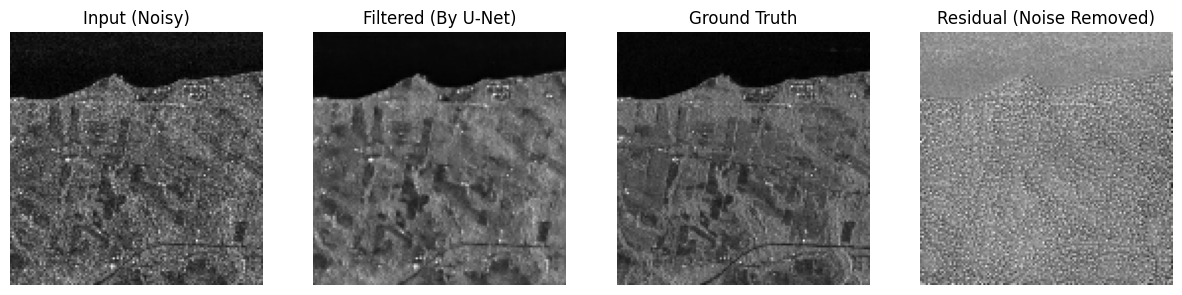

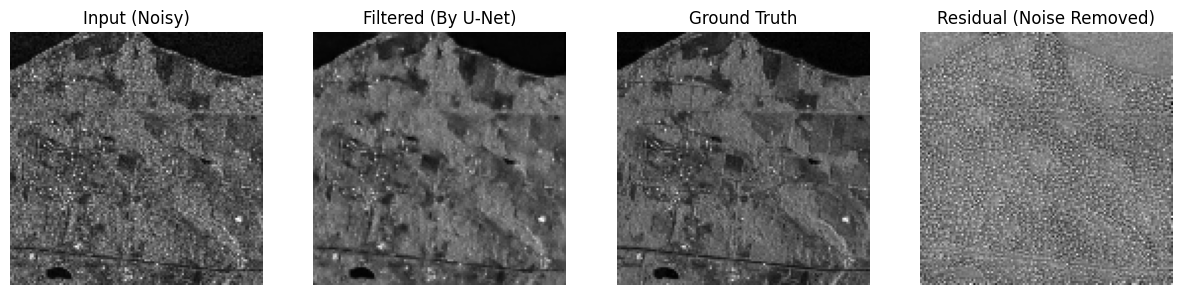

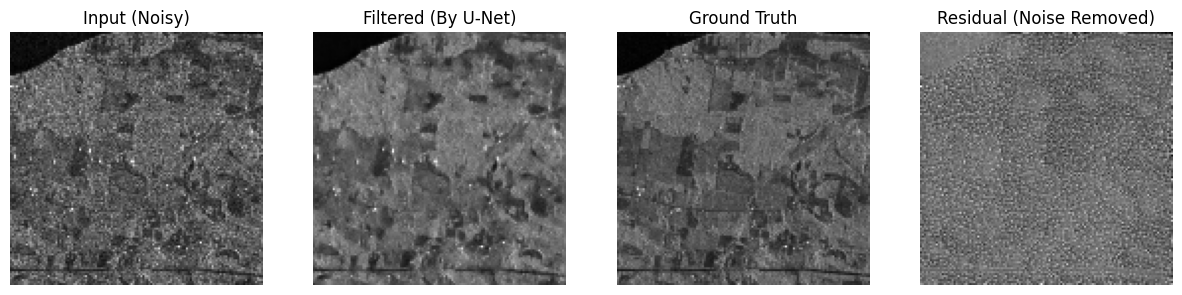

In [36]:
best_finetuned = tf.keras.models.load_model(
    'best_sar_model_finetuned.h5',
    custom_objects={'advanced_loss': advanced_loss, 'psnr_metric': psnr_metric}
)
val_noisy_ft, val_clean_ft = next(val_gen)
denoised_ft = best_finetuned.predict(val_noisy_ft, verbose=0)
for i in range(3):
    plot_results(val_noisy_ft, val_clean_ft, denoised_ft, index=i)

### Final Result

In [37]:
# Final Evaluation
avg_psnr_ft = 0
avg_ssim_ft = 0
count_ft = 0

for _ in range(16):
    batch_noisy, batch_clean = next(val_gen)
    batch_pred = best_finetuned.predict(batch_noisy, verbose=0)

    for i in range(len(batch_noisy)):
        true = batch_clean[i].squeeze()
        pred = batch_pred[i].squeeze()

        avg_psnr_ft += psnr(true, pred, data_range=1.0)
        avg_ssim_ft += ssim(true, pred, data_range=1.0)
        count_ft += 1

print("\nFinal Fine-Tuned Scores:")
print(f"   - Average PSNR: {avg_psnr_ft/count_ft:.2f} dB")
print(f"   - Average SSIM: {avg_ssim_ft/count_ft:.4f} ")


Final Fine-Tuned Scores:
   - Average PSNR: 23.70 dB
   - Average SSIM: 0.7813 
